# Temporal Forecast Reconciliation in `forecastML`
### *Nick Redell* nickalusredell@gmail.com
### 2020-05-21

***

# Purpose

The goal of this notebook is demonstrate how machine learning and statistical forecasts can be reconciled to produce a coherent forecast over various planning horizons (e.g., monthly and annually). Using (a) ML methods to forecast time series with higher frequencies (e.g., weekly) and lots of data and (b) statistical methods to forecast time series with lower frequencies (e.g., quarterly) is a complementary approach to forecasting.

The benefits of temporal forecast reconciliation are two-fold:
   1. **Improved forecast accuracy**.
   2. After reconciliation, forecasts at higher levels of aggregation (e.g., yearly) are simply the sum of the relevant lowest-level forecast (e.g., monthly) which allows **operational, tactical, and strategic plans to be based off of the same forecast**.

# `forecastML::reconcile_forecasts()`

* The method implemented is temporal forecast reconciliation with structural scaling from:  
  
  Athanasopoulos, G., Hyndman, R. J., Kourentzes, N., & Petropoulos, F. (2017). [Forecasting with temporal hierarchies](https://robjhyndman.com/publications/temporal-hierarchies/). European Journal of Operational Research, 262(1), 60-74.


* `reconcile_forecasts()` works with forecasts from **any package**.


* `reconcile_forecasts()` works with forecasts at **any forecast horizon frequency** from seconds to years.

***

# Example: Reconciling weekly and monthly forecasts

## Task

* **Domain:** Ansett Airlines economy passenger counts over several years
* **Number of time series:** 10
* **Frequency of data collection:** 1 week
* **Forecast horizon:** 4-months-ahead
* **Method:** Temporal hierarchical forecast reconciliation (forecasts are *not* reconciled across groups)
* **Model outcome:** passengers
* **Models:**
    + ARIMA at the monthly level from the `fable` package
    + LASSO at the weekly level from `glmnet` with `forecastML`

## Final Product
  
<p>
  
<div>
<img src="forecast_comparison.png"/>
</div>

***

## `R` Setup

In [29]:
options(warn = -1)
options(repr.plot.width = 12, repr.plot.height = 6)

library(dplyr)
library(lubridate)
library(ggplot2)
library(tsibble)  # Time series data.frames.
library(tsibbledata)
library(fable)  # Statistical forecasting.
library(forecastML)  # v0.9.1
library(glmnet)  # LASSO model in R.

***

## Data Preparation

* Load the example data.

In [2]:
data(ansett, package = "tsibbledata")

data <- as.data.frame(ansett)

names(data) <- tolower(names(data))

# This dataset has two levels of grouping--airport and class. We'll select one class for analysis.
data <- data %>%
  dplyr::filter(class == "Economy") %>%
  dplyr::select(-class)

head(data)

,week,airports,passengers
,<week>,<chr>,<dbl>
1,1987 W26,ADL-PER,2084
2,1987 W27,ADL-PER,2186
3,1987 W28,ADL-PER,2137
4,1987 W29,ADL-PER,2090
5,1987 W30,ADL-PER,1595
6,1987 W31,ADL-PER,1908


In [3]:
airport_list <- unique(data$airports)
airport_list

[1] "ADL-PER" "MEL-ADL" "MEL-BNE" "MEL-OOL" "MEL-PER" "MEL-SYD" "SYD-ADL"
 [8] "SYD-BNE" "SYD-OOL" "SYD-PER"

### Date features for aggregation

* Let's create several date features that will allow us to aggregate the passenger totals at the weekly and monthly levels. We could use thse features with our LASSO model in `forecastML`, but we'll skip that this time.

In [4]:
data$month <- lubridate::month(data$week)
data$quarter <- lubridate::quarter(data$week)
data$year <- lubridate::year(data$week)

head(data)

,week,airports,passengers,month,quarter,year
,<week>,<chr>,<dbl>,<dbl>,<int>,<dbl>
1,1987 W26,ADL-PER,2084,6,2,1987
2,1987 W27,ADL-PER,2186,6,2,1987
3,1987 W28,ADL-PER,2137,7,3,1987
4,1987 W29,ADL-PER,2090,7,3,1987
5,1987 W30,ADL-PER,1595,7,3,1987
6,1987 W31,ADL-PER,1908,7,3,1987


***

## Monthly Forecasts with ARIMA

* Check out the [tidyverts](https://tidyverts.org/) for more info on the tidy approach to forecasting in `R`. I'm a fan.

In [5]:
data_month <- data
data_month$index <- as.Date(paste0(data_month$year, "-", data_month$month, "-01"))
data_month$index <- tsibble::yearmonth(data_month$index)

In [6]:
# Monthly aggregation.
data_month <- data_month %>%
  dplyr::group_by(airports, index) %>%
  dplyr::summarize("passengers" = sum(passengers, na.rm = TRUE)) %>%
  dplyr::ungroup()

In [7]:
data_month <- tsibble::as_tsibble(data_month, key = airports, index = index)

data_month <- tsibble::fill_gaps(data_month)

head(data_month)

airports,index,passengers
<chr>,<mth>,<dbl>
ADL-PER,1987 Jun,4270
ADL-PER,1987 Jul,7730
ADL-PER,1987 Aug,9809
ADL-PER,1987 Sep,9300
ADL-PER,1987 Oct,9181
ADL-PER,1987 Nov,11473


* Fit a separate ARIMA model to each of the 10 airports with one line of code.

In [8]:
model_month <- data_month %>% fabletools::model(arima = fable::ARIMA(passengers))

* Forecast 4 months into the future.

In [9]:
data_forecasts_month <- forecast(model_month, h = "4 months")

* Plot forecasts for 3 of the 10 airports.


* These forecasts look fairly flat. Hopefully, we can boost the signal in the monthly time series by reconciling these forecasts with the weekly forecasts.

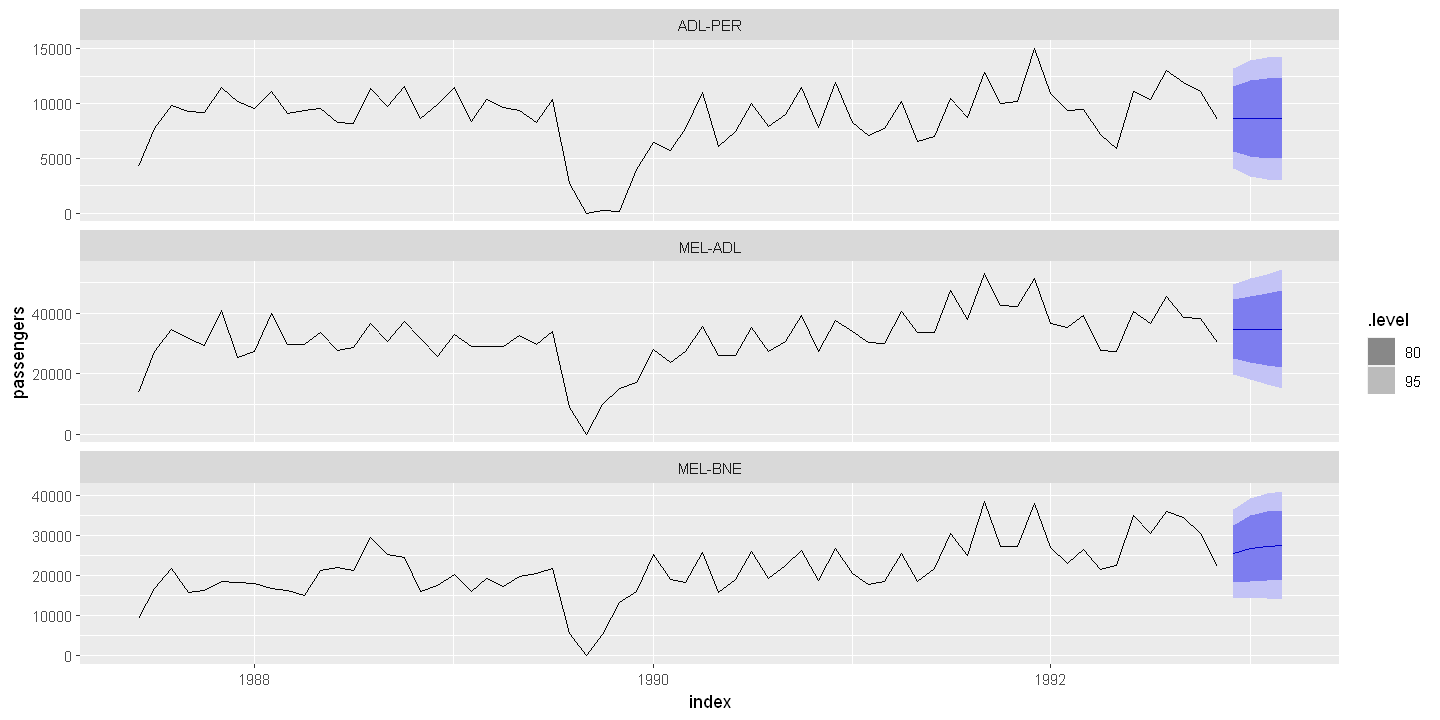

In [10]:
data_forecasts_month %>%
  dplyr::filter(airports %in% airport_list[1:3]) %>%
  autoplot(dplyr::filter(data_month, airports %in% airport_list[1:3]))

***

## Weekly Forecasts with the LASSO in `forecastML`

* I'll skip most of the step-by-step explanation about how to use `forecastML`. Refer to the package vignettes, cheat sheets, or other notebooks if additional context is needed.


* Our highest level forecast model is producing monthly forecasts at a horizon of ~16 weeks, sometimes more depending on whether or not a month has 5 weeks. To be safe, we'll build a model that can forecast 20 weeks into the future and simply discard the excess forecasts during reconciliation.  `reconcile_forecasts()` takes care of all the date alignments.

In [11]:
data_week <- data

data_week[, c("month", "quarter", "year")] <- NULL  # We could use these as dynamic features.

data_week$week <- as.Date(data_week$week)

data_week$airports <- as.factor(data_week$airports)  # For modeling.

data_week <- forecastML::fill_gaps(data_week, date_col = 1, frequency = "1 week", groups = "airports")

head(data_week)

,week,airports,passengers
,<date>,<fct>,<dbl>
1,1987-06-22,ADL-PER,2084
2,1987-06-29,ADL-PER,2186
3,1987-07-06,ADL-PER,2137
4,1987-07-13,ADL-PER,2090
5,1987-07-20,ADL-PER,1595
6,1987-07-27,ADL-PER,1908


### `forecastML::create_lagged_df(type = "train")`

In [12]:
# The column position of our 'passengers' outcome (after removing the date column).
# The outcome will be moved to the first position in the resulting lagged data.frames.
outcome_col <- 2

# Forecast 1, 1:4, ... 1:20 weeks into the future in 1-week increments.
horizons <- c(1, 4, 8, 12, 16, 20)

# Feature lags in 1 week intervals. Notice that feature lags that do not support direct forecasting at 
# a given horizon are silently dropped.
lookback <- 1:53

groups <- "airports"

dates <- data_week$week

# We don't need or want dates/times in the modeling dataset.
data_week$week <- NULL

frequency <- "1 week"

data_train <- forecastML::create_lagged_df(data_week, type = "train", outcome_col = outcome_col,
                                           lookback = lookback, horizon = horizons,
                                           dates = dates, frequency = frequency,
                                           groups = groups
                                           )

head(data_train$horizon_4)  # View the horizon-4 dataset.

,passengers,airports,passengers_lag_4,passengers_lag_5,passengers_lag_6,passengers_lag_7,passengers_lag_8,passengers_lag_9,passengers_lag_10,passengers_lag_11,...,passengers_lag_44,passengers_lag_45,passengers_lag_46,passengers_lag_47,passengers_lag_48,passengers_lag_49,passengers_lag_50,passengers_lag_51,passengers_lag_52,passengers_lag_53
,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2084,ADL-PER,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,2186,ADL-PER,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,2137,ADL-PER,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,2090,ADL-PER,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,1595,ADL-PER,2084,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,1908,ADL-PER,2186,2084,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


### `forecastML::create_windows(window_length = 0)`

* Train over all historical data without creating any external validation windows.


* That dip in 1989 is not an aggregation error. There was a pilots' strike.

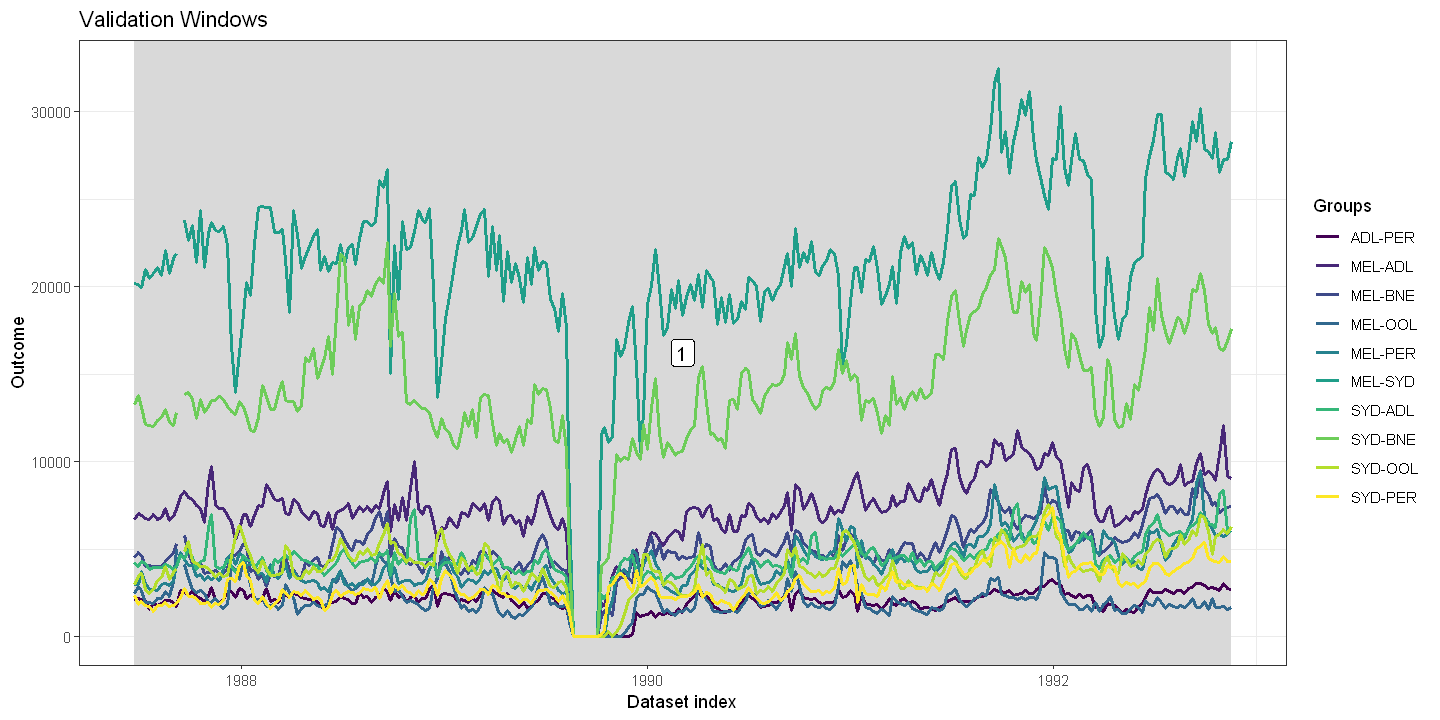

In [13]:
windows <- forecastML::create_windows(data_train, window_length = 0)

plot(windows, data_train)

### `forecastML::train_model()`

In [14]:
model_fun <- function(data, outcome) {  # 'outcome' is not a required argument.

  data <- data[complete.cases(data), ]  # With grouped data and feature lags, there will be NAs.

  x <- model.matrix(as.formula(paste0(outcome, "~ .")), data)

  y <- as.matrix(data[, outcome, drop = FALSE])

  set.seed(224)
  model <- glmnet::cv.glmnet(x, y)
}

model_week <- forecastML::train_model(data_train,
                                         windows,
                                         model_name = "LASSO",  # Can be any name.
                                         model_function = model_fun,
                                         outcome = "passengers"  # Passed in ...
                                         )

### `forecastML::predict()`

In [15]:
predict_function <- function(model, data) {

  x <- model.matrix(~ ., data)

  data_pred <- data.frame("y_pred" = predict(model, x))
}

data_forecast <- forecastML::create_lagged_df(data_week, type = "forecast", outcome_col = outcome_col,
                                              lookback = lookback, horizon = horizons,
                                              dates = dates, frequency = frequency,
                                              groups = groups
                                              )

data_forecasts <- predict(model_week, prediction_function = list(predict_function), data = data_forecast)

# Combine the short- and long-horizon direct forecasts.
data_forecasts_week <- forecastML::combine_forecasts(data_forecasts)

### `forecastML::plot()`

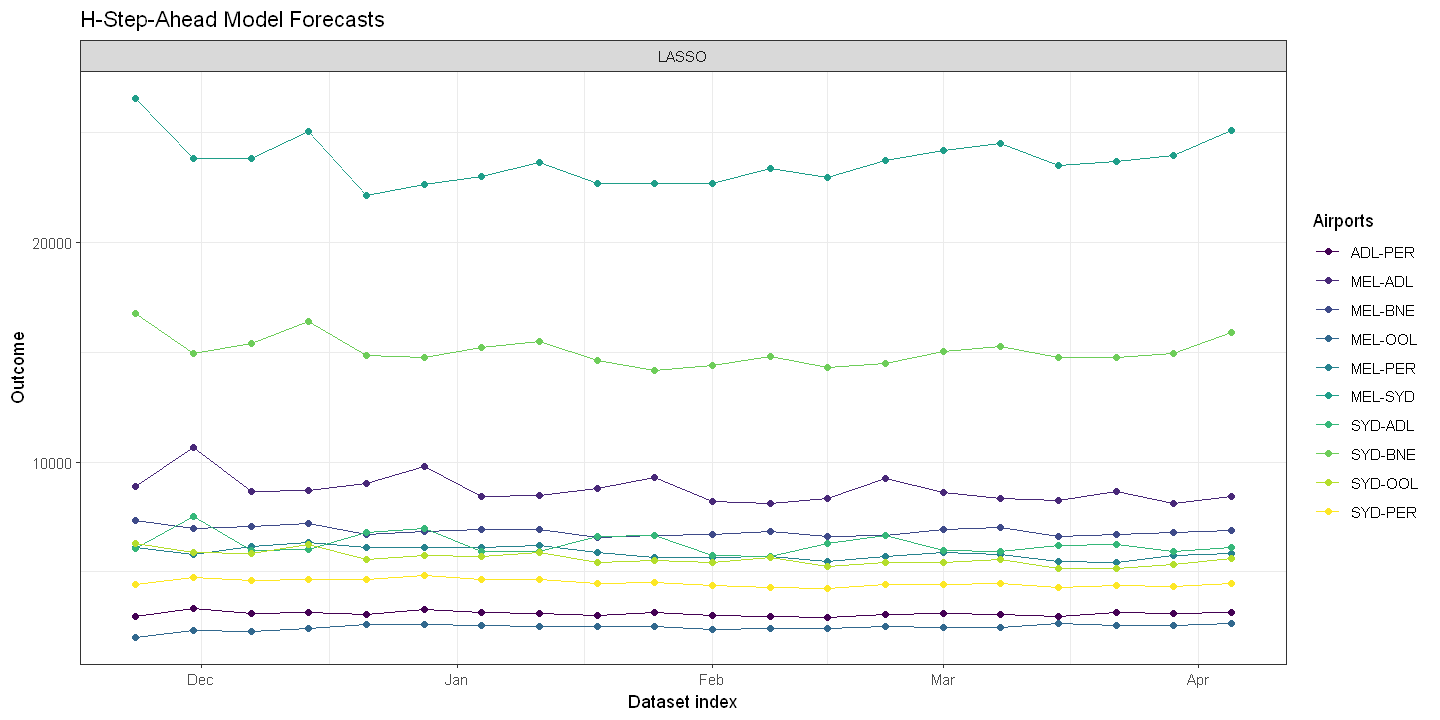

In [16]:
plot(data_forecasts_week)

***

## Forecast Reconciliation

`reconcile_forecasts()` has very few restrictions on the input forecasts. Here they are:

* The forecasts being reconciled must have a **column of dates or datetimes** (dates and times can be combined).


* The date column, `index`, and column of forecasts, `outcome`, need to **have the same name across forecasts**.


* The lowest frequency forecast--i.e., the forecast at the highest level of aggregation--provides the bookend date ranges for forecast reconciliation. **All lower-level forecasts--weekly in our example--need to be present within this date range**. Lower-level forecasts can be made for dates before or after this date range but they will not factor into the reconciliation. They can optionally be returned un-reconciled with `keep_non_reconciled = TRUE`. This functionality was added with ease of use in mind.

### Renaming date and forecast columns to be the same across the weekly and monthly datasets

In [17]:
data_forecasts_month$index <- as.Date(data_forecasts_month$index)

names(data_forecasts_week)[names(data_forecasts_week) == "forecast_period"] <- "index"

names(data_forecasts_week)[names(data_forecasts_week) == "passengers_pred"] <- "passengers"

### Creating a list of forecasts to reconcile

* `reconcile_forecasts()` does not currently work with grouped hierarchical forecasts. So we'll split the forecasts into a list of 10 data.frames--1 for each airport--and reconcile forecasts 1 group at a time.


* If you're reconciling multiple time series using an approach similar to below, make sure that the groups are in the same order prior to `dplyr::group_split()`! They're in the same order in this example.

In [18]:
data_reconcile_month <- data_forecasts_month %>%
  dplyr::group_by(airports) %>%
  dplyr::group_split(airports)

data_reconcile_week <- data_forecasts_week %>%
  dplyr::group_by(airports) %>%
  dplyr::group_split(airports)

* Here is the list of forecasts being reconciled for ADL-PER. The extra columns don't matter; both have the common columns "index" and "passengers".

In [19]:
data_reconcile_month[[1]]

data_reconcile_week[[1]]

airports,.model,index,passengers,.distribution
<chr>,<chr>,<date>,<dbl>,<dist>
ADL-PER,arima,1992-12-01,8601.110,"N(8601, 5407865)"
ADL-PER,arima,1993-01-01,8623.424,"N(8623, 7363186)"
ADL-PER,arima,1993-02-01,8636.841,"N(8637, 8070171)"
ADL-PER,arima,1993-03-01,8644.910,"N(8645, 8325795)"


model,model_forecast_horizon,horizon,airports,index,passengers
<chr>,<dbl>,<dbl>,<fct>,<date>,<dbl>
LASSO,1,1,ADL-PER,1992-11-23,2942.520
LASSO,4,2,ADL-PER,1992-11-30,3320.056
LASSO,4,3,ADL-PER,1992-12-07,3115.462
LASSO,4,4,ADL-PER,1992-12-14,3123.974
LASSO,8,5,ADL-PER,1992-12-21,3053.807
LASSO,8,6,ADL-PER,1992-12-28,3263.941
LASSO,8,7,ADL-PER,1993-01-04,3137.612
LASSO,8,8,ADL-PER,1993-01-11,3106.625
LASSO,12,9,ADL-PER,1993-01-18,2998.464


### `forecastML::reconcile_forecasts()`

* The return value is either (a) a list of reconciled forecasts with `length(forecasts)` if `keep_all = TRUE` or (b) the bottom-level forecast at the most disaggregated level if `keep_all = FALSE`.


* If you look closely at the lists above, you'll see that there are 2 weekly forecasts in November 1992 that occur before the bookend forecast start date of our highest level forecast--1992-12-01. These forecasts, correctly, are not included in the forecast reconciliation, but they can be returned with the reconciled forecasts if `keep_non_reconciled = TRUE`. There's also an extra forecast for 1993-04-05 and the same rules apply here.

In [20]:
data_reconciled <- vector("list", length(airport_list))

for (i in seq_along(airport_list)) {

  forecasts <- list(data_reconcile_week[[i]], data_reconcile_month[[i]])

  frequency <- c("1 week", "1 month")

  data_reconciled[[i]] <- forecastML::reconcile_forecasts(forecasts,
                                                          frequency = frequency,
                                                          index = "index",  # Date column.
                                                          outcome = "passengers",  # Forecast column.
                                                          method = "temporal",
                                                          keep_all = TRUE,  # FALSE returns weekly.
                                                          keep_non_reconciled = FALSE
                                                          )
    
  # We'll add the airport to the list of weekly and monthly forecasts for plotting.
  data_reconciled[[i]] <- lapply(data_reconciled[[i]], function(x) {x$airports <- airport_list[i]; x})
}

# Reconciled forecasts for ADL-PER.
data_reconciled[[1]]

index,passengers,airports
<date>,<dbl>,<chr>
1992-12-07,2620.952,ADL-PER
1992-12-14,2629.465,ADL-PER
1992-12-21,2559.297,ADL-PER
1992-12-28,2769.431,ADL-PER
1993-01-04,2668.451,ADL-PER
1993-01-11,2637.464,ADL-PER
1993-01-18,2529.303,ADL-PER
1993-01-25,2664.849,ADL-PER
1993-02-01,2588.064,ADL-PER


### Check that the forecast reconciliation is working as intended

* These values should be equal if `keep_non_reconciled = FALSE`.

In [21]:
# ADL-PER
sum(data_reconciled[[1]][["1 month"]]$passengers)

sum(data_reconciled[[1]][["1 week"]]$passengers)

[1] 43380.27

[1] 43380.27

### Custom plot - Forecasts vs. reconciled forecasts

* The cell below has some boilerplate code for combining the historical data, forecasts, and reconciled forecasts for creating a custom plot. There is currently no `plot()` method in `forecastML` that does this.

In [22]:
#----------
data_reconciled <- dplyr::bind_rows(unlist(data_reconciled, recursive = FALSE), .id = "frequency")
data_reconciled$reconciled <- "Reconciled"
#----------
data_forecasts_week$frequency <- frequency[1]
data_forecasts_month$frequency <- frequency[2]

data_forecasts <- dplyr::bind_rows(data_forecasts_week, data_forecasts_month)
data_forecasts$reconciled <- "Not reconciled"
#----------
data_week$index <- dates

data_week$frequency <- frequency[1]
data_month$frequency <- frequency[2]

data_history <- dplyr::bind_rows(data_week, data_month)

data_history$reconciled <- "Historical"
#----------
data_plot <- dplyr::bind_rows(data_forecasts, data_reconciled, data_history)

data_plot <- dplyr::filter(data_plot, lubridate::year(index) >= 1992)

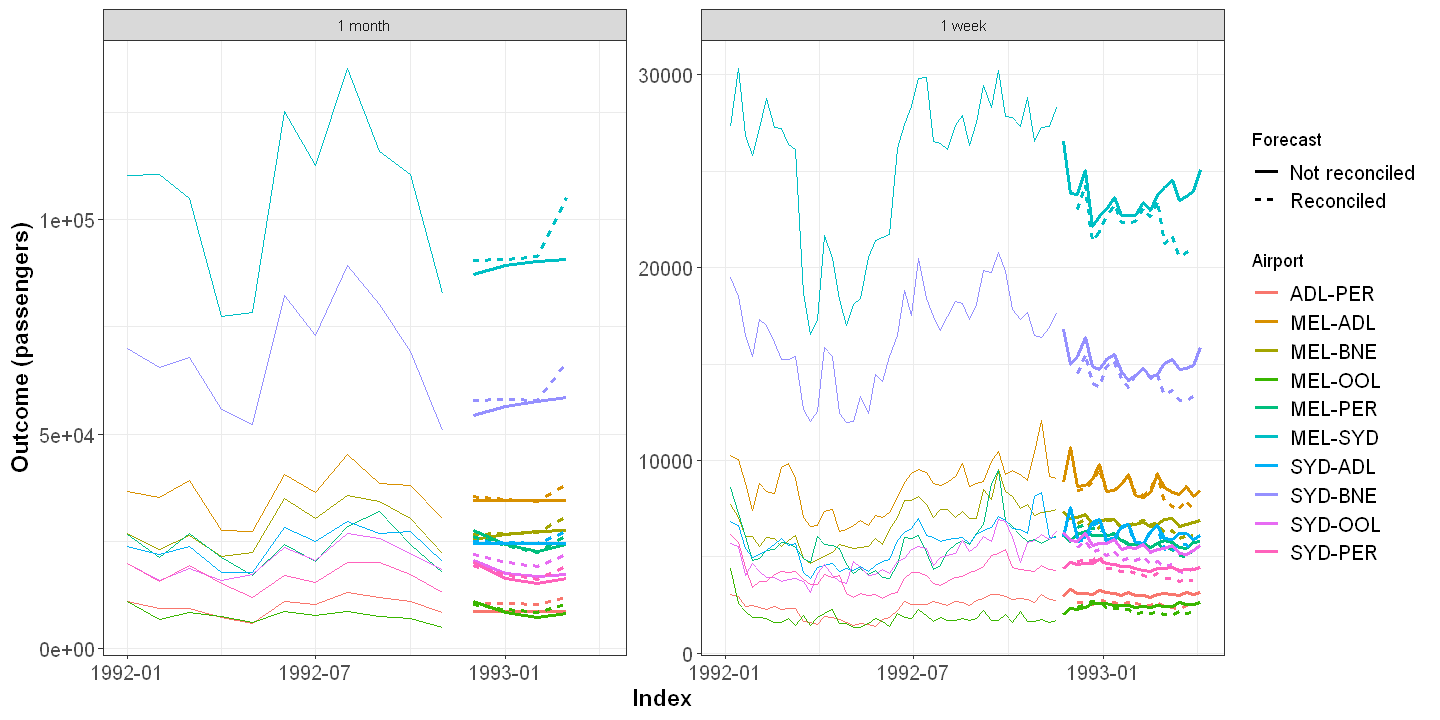

In [23]:
p <- ggplot()
p <- p + geom_line(data = data_plot[data_plot$reconciled == "Historical", ], aes(index, passengers, color = airports))
p <- p + geom_line(data = data_plot[data_plot$reconciled != "Historical", ], aes(index, passengers, color = airports, linetype = reconciled), size = 1.05)
p <- p + facet_wrap(~ frequency, scales = "free_y")
p <- p + theme_bw() + theme(
    plot.title = element_text(size = 16, face = "bold"),
    axis.title = element_text(size = 14, face = "bold"),
    axis.text = element_text(size = 12),
    legend.text = element_text(size = 12)
  )
p <- p + xlab("Index") + ylab("Outcome (passengers)") + labs(color = "Airport", linetype = "Forecast")
p

ggsave(file = "forecast_comparison.png", width = 9, height = 6)

***

## Bonus Analysis!

* At this point, we have an ML model that forecasts at the weekly level and a statistical model that forecasts at the monthly level. Both are forecasting ~4 months into the future.


* What happens if we'd like to quickly **incorporate a judgment forecast** into the mix?

### Taking stock of where we are at

* Let's make this scenario of adding a judgment forecast specific to ADL-PER.

In [24]:
forecast_start_date <- min(data_reconcile_month[[1]]$index)
forecast_stop_date <- max(data_reconcile_month[[1]]$index) %m+% months(1) - 1

# From our dplyr::group_split(), index [[1]] is "ADL-PER".
monthly_forecast <- sum(data_reconcile_month[[1]][, "passengers"])

weekly_forecast <- sum(data_reconcile_week[[1]][][data_reconcile_week[[1]]$index >= forecast_start_date & 
                                                  data_reconcile_week[[1]]$index <= forecast_stop_date, "passengers"])

reconciled_forecast <- sum(data_reconciled[data_reconciled$airports == "ADL-PER" & 
                                           data_reconciled$frequency == frequency[1], "passengers"])

In [25]:
paste0("The 4-month-ahead total for ADL-PER with monthly forecasts is: ", round(monthly_forecast))
paste0("The 4-month-ahead total for ADL-PER with weekly forecasts is: ", round(weekly_forecast))
paste0("The 4-month-ahead total for ADL-PER with reconciled forecasts is: ", round(reconciled_forecast))

[1] "The 4-month-ahead total for ADL-PER with monthly forecasts is: 34506"

[1] "The 4-month-ahead total for ADL-PER with weekly forecasts is: 52254"

[1] "The 4-month-ahead total for ADL-PER with reconciled forecasts is: 43380"

### Adding a judgment forecast

* If someone comes in with a 4-month-out judgment forecast for ADL-PER at 60,000, what needs to be done? Simply make a data.frame like below with a date column and forecast column matching the weekly and monthly datasets.

In [26]:
data_reconcile_quarter <- data.frame("index" = as.Date("1992-12-01"), "passengers" = 60000L)

data_reconcile_quarter

index,passengers
<date>,<int>
1992-12-01,60000


### Run `forecastML::reconcile_forecasts()`

In [27]:
# ADL-PER: Unreconciled weekly, monthly, and quarterly forecasts are the inputs.
forecasts <- list(data_reconcile_week[[1]], data_reconcile_month[[1]], data_reconcile_quarter)

frequency <- c("1 week", "1 month", "4 months")

reconciled_forecast_ADL_PER <- forecastML::reconcile_forecasts(forecasts,
                                                               frequency = frequency,
                                                               index = "index",
                                                               outcome = "passengers",
                                                               method = "temporal",
                                                               keep_all = TRUE,
                                                               keep_non_reconciled = FALSE
                                                               )

* **The new 4-monthly estimate of 60,000 raised the reconciled total forecast from 43,380 to 48,920.**

In [28]:
reconciled_forecast_ADL_PER[["4 months"]]

index,passengers
<date>,<dbl>
1992-12-01,48920.18
